# Zadanie 6
Segmentacja obrazu na podstawie danych CamVid:
• Zadanie polega na stworzeniu modelu głębokiej sieci neuronowej w Keras do segmentacji
obrazu na podstawie danych z bazy danych CamVid.
• Użyj bazy danych CamVid, która zawiera obrazy dróg z kamery samochodu oraz ich odpowiadające etykiety pikseli.
• Zdefiniuj architekturę modelu, skompiluj go i przeprowadź proces trenowania.
• Ocenić wydajność modelu za pomocą miary IoU (Intersection over Union) oraz zwizualizuj
wyniki segmentacji dla wybranych obrazów z zestawu testowego.

In [26]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

In [94]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Funkcja do ładowania obrazów i masek
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(image_dir, img_file))
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Ścieżki do katalogów z obrazami i maskami
image_dir = 'data/Camvid/CamVid_RGB'
mask_dir = 'data/Camvid/CamVid_Label'

# Załadowanie danych
images, masks = load_images_and_masks(image_dir, mask_dir)

print(f"Maski przed zmianami {masks}")
print(f"Klasy w tych maskach {len(np.unique(masks))}")

# Podział danych - 80% na trening, 20% na testy
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Przetwarzanie danych
def preprocess_data(images, masks, target_size):
    images_prep = [cv2.resize(img, target_size) / 255.0 for img in images]
    masks_prep = [cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST) for mask in masks]
    masks_prep = [np.expand_dims(mask, axis=-1) for mask in masks_prep]  # Dodanie wymiaru kanału

    return np.array(images_prep), np.array(masks_prep)

target_size = (32, 32)  
images_train_prep, masks_train_prep = preprocess_data(images_train, masks_train, target_size)
images_test_prep, masks_test_prep = preprocess_data(images_test, masks_test, target_size)

Maski przed zmianami [[[ 38  38  38 ...  38  38  38]
  [ 38  38  38 ...  38  38  38]
  [ 38  38  38 ...  38  38  38]
  ...
  [ 21  21  21 ...   0   0   0]
  [ 21  21  21 ...   0   0   0]
  [ 21  21  21 ...   0   0   0]]

 [[ 38  38  38 ...  38  38  38]
  [ 38  38  38 ...  38  38  38]
  [ 38  38  38 ...  38  38  38]
  ...
  [ 21  21  21 ...   0   0   0]
  [ 21  21  21 ...   0   0   0]
  [ 21  21  21 ...   0   0   0]]

 [[ 38  38  38 ...  38  38  38]
  [ 38  38  38 ...  38  38  38]
  [ 38  38  38 ...  38  38  38]
  ...
  [ 21  21  21 ...   0   0   0]
  [ 21  21  21 ...   0   0   0]
  [ 21  21  21 ...   0   0   0]]

 ...

 [[ 38  38  38 ... 128 128 128]
  [ 38  38  38 ... 128 128 128]
  [ 38  38  38 ... 128 128 128]
  ...
  [ 21  21  21 ...  90  90  90]
  [ 21  21  21 ...  90  90  90]
  [ 21  21  21 ...  90  90  90]]

 [[  0   0   0 ... 128 128 128]
  [  0   0   0 ... 128 128 128]
  [  0   0   0 ... 128 128 128]
  ...
  [ 21  21  21 ...  90  90  90]
  [ 21  21  21 ...  90  90  90]
  [ 21 

In [89]:
np.unique(masks_train_prep)

array([  0,   7,  21,  26,  33,  38,  41,  44,  53,  56,  59,  60,  61,
        64,  71,  72,  74,  78,  79,  82,  83,  90,  96,  97,  99, 101,
       113, 116, 120, 122, 123, 128, 131, 135, 139, 146, 147, 151, 154,
       170, 184, 186], dtype=uint8)

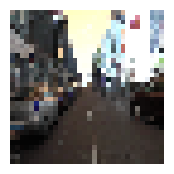

In [90]:
# Wyświetlenie przykładowego zdjęcia
plt.figure(figsize=(2,2))  # Ustawienie rozmiaru figury
plt.imshow(images_train_prep[3], cmap='BuPu')  # Wyświetlenie pierwszego zdjęcia w zbiorze treningowym
plt.axis('off')  # Wyłączenie osi
plt.show()

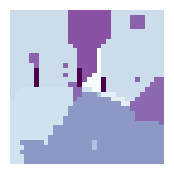

In [91]:
# Wyświetlenie labela tego zdjęcia
plt.figure(figsize=(2,2))  # Ustawienie rozmiaru figury
plt.imshow(masks_train_prep[3], cmap='BuPu')  # Wyświetlenie pierwszego zdjęcia w zbiorze treningowym
plt.axis('off')  # Wyłączenie osi
plt.show()

In [76]:
def preprocess_masks(masks, num_classes):
    masks_one_hot = np.zeros(masks.shape[:3] + (num_classes,), dtype=np.float32)
    for i in range(num_classes):
        masks_one_hot[..., i] = (masks[..., 0] == i).astype(np.float32)
    return masks_one_hot

num_classes = 32  # Liczba klas w zbiorze danych CamVid
masks_train_one_hot = preprocess_masks(masks_train_prep, num_classes)
masks_test_one_hot = preprocess_masks(masks_test_prep, num_classes)

In [96]:
print(masks_train_one_hot)
print(len(np.unique(masks_train_one_hot)))

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 

In [82]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# jeden z modeli który znalazłem w internecie
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

input_shape = (32, 32, 3)
model = unet_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_228 (Conv2D)         (None, 32, 32, 64)           1792      ['input_13[0][0]']            
                                                                                                  
 conv2d_229 (Conv2D)         (None, 32, 32, 64)           36928     ['conv2d_228[0][0]']          
                                                                                                  
 max_pooling2d_48 (MaxPooli  (None, 16, 16, 64)           0         ['conv2d_229[0][0]']          
 ng2D)                                                                                     

In [83]:
history = model.fit(images_train_prep, masks_train_one_hot, epochs=2, batch_size=8, validation_split=0.1)

Epoch 1/2
63/63 [==============================] - 120s 2s/step - loss: nan - accuracy: 0.2530 - val_loss: nan - val_accuracy: 0.9999
Epoch 2/2
63/63 [==============================] - 81s 1s/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.9999


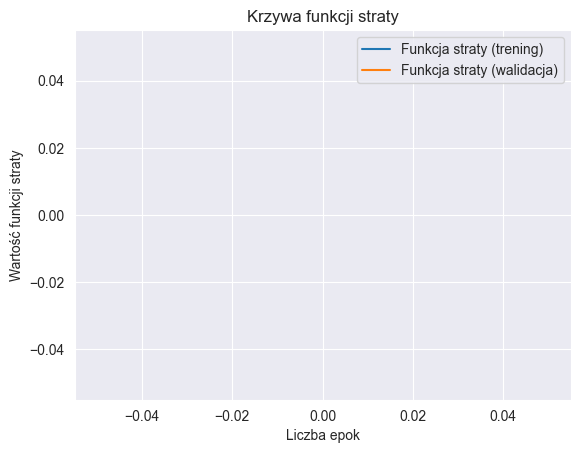

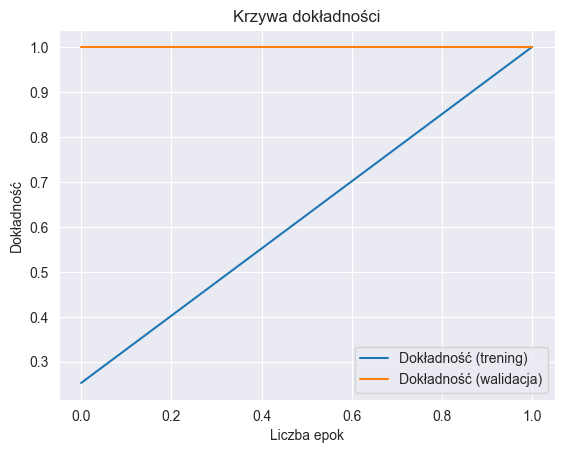

In [84]:
# Wizualizacja krzywych uczenia
plt.plot(history.history['loss'], label='Funkcja straty (trening)')
plt.plot(history.history['val_loss'], label='Funkcja straty (walidacja)')
plt.xlabel('Liczba epok')
plt.ylabel('Wartość funkcji straty')
plt.legend()
plt.title('Krzywa funkcji straty')
plt.show()
plt.plot(history.history['accuracy'], label='Dokładność (trening)')
plt.plot(history.history['val_accuracy'], label='Dokładność (walidacja)')
plt.xlabel('Liczba epok')
plt.ylabel('Dokładność')
plt.legend()
plt.title('Krzywa dokładności')
plt.show()

In [85]:
# Tworzenie Predykcji
masks_pred = model.predict(images_test_prep)

5/5 [==============================] - 5s 717ms/step


In [86]:
# Wartości predykcji przed zmianą na binarne
masks_pred

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Czułość modelu:
recall = recall_score(masks_test, masks_pred, average='micro')
print("Czułość modelu: {:.2f}%".format(recall * 100))

# Obliczenie precyzji
precision = precision_score(masks_test, masks_pred, average='micro')
print("Precyzja modelu: {:.2f}%".format(precision * 100))

# Obliczenie dokładności modelu
accuracy = accuracy_score(masks_test, masks_pred,)
print("Dokładność modelu:", accuracy)

ValueError: unknown is not supported